### we simply need to compare output of edge, and agglo clustering
### and where agglo clustering is 1 we leave to 1 and do not take the 
### predictions from edge model

In [8]:
import numpy as np
from numpy import genfromtxt
from itertools import combinations
import torch
import math 
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%run r3b_clustering_def.ipynb
%run agglomerative_def.ipynb
%run ff_models_def.ipynb

In [10]:
def get_agglo_edge_ene(data,agglo_vals,edge_vals,true_vals):
    ene_list = []
    ene_true_list = []
    idx = 0
    well_reco = 0
    array_unique_events = np.unique(data[:,0])
    merge_tries = 0
    correctly_merged = 0
    nr_events = 0
    nr_t = 0
    nr_fp = 0
    nr_fn = 0
    nr_fpfn = 0
    
    for i in range(0,int(np.max(data,axis=0)[0])-(int(np.max(data,axis=0)[0])%3) ,3):
        nr_events += 1
        mask = ((data[:,0] == i) | (data[:,0] == i+1) | (data[:,0] == i+2))
        evt = data[mask]
        pair_indices = list(combinations(range(evt.shape[0]), 2))
        ##pair indices which belong together...
        pred_comb = []
        ##TJ this is the new part with true stuff
        true_comb = []
        for m in range(evt.shape[0]):
            pred_comb.append((m,m))
            true_comb.append((m,m))
        for j in range (len(pair_indices)):
            if agglo_vals[idx+j] > 0.75:
                pred_comb.append(pair_indices[j])
            if ((agglo_vals[idx+j] < 0.75) and (edge_vals[idx+j] > 0.75)):
                merge_tries +=1
                pred_comb.append(pair_indices[j])
                if true_vals[idx+j] > 0.75: 
                    correctly_merged +=1
            if true_vals[idx+j] > 0.75:   
                true_comb.append(pair_indices[j])
        G = nx.Graph()
        G.add_edges_from(pred_comb)
        connected_components = list(nx.connected_components(G))
        ##TJ again, this it the addition for the true values
        T = nx.Graph()
        T.add_edges_from(true_comb)
        true_components = list(nx.connected_components(T))
        set_true = {frozenset(sublist) for sublist in true_components}
        set_pred = {frozenset(sublist) for sublist in connected_components}
        
        evt_type =  check_matrix(set_true,set_pred)
        if (evt_type == "t"):
            nr_t += 1
        if (evt_type == "fp"):
            nr_fp += 1
        if (evt_type == "fn"):
            nr_fn +=1
        if (evt_type == "fpfn"):
            nr_fpfn += 1
            
        # Find the intersection of the two sets
        common_sublists = set_true.intersection(set_pred)

        well_reco += len(common_sublists)
        for k in range(len(connected_components)):
            columns_to_sum = evt[list(connected_components[k]),1]
            ene = np.sum(columns_to_sum)
            ene_list.append(ene)
        #make list true energy
        for l in range(len(true_components)):
            true_columns_to_sum = evt[list(true_components[l]),1]
            ene_true = np.sum(true_columns_to_sum)
            ene_true_list.append(ene_true)
        idx += len(pair_indices)
    single_hit_energies = []
    for i in range(data.shape[0]):
        single_hit_energies.append(data[i,1])
        
    #plt.hist(single_hit_energies,bins=70,range=(0,7),label="single hit energy",color="green",alpha=0.5)    
    plt.hist(ene_list,bins=100,range=(0,10),label="reconstructed energy",color="red",alpha=0.3)
    plt.grid()
    plt.hist(ene_true_list,bins=100,range=(0,10),label="true energies",color="blue",alpha=0.3)
    plt.legend()
    plt.yscale('log')
    well_reco = float(well_reco)/float(np.max(data,axis=0)[0])
    print("merge tries:\t", merge_tries)
    print("correctly merged:\t",correctly_merged) 
    print("percentage of correctly merged hits/clusters:")
    print(correctly_merged/merge_tries)

    print("well reco...", well_reco)
    print("---more statistics....---")
    print("fully true_reco_cluster:\t", nr_t/nr_events)
    print("false positive events:\t" , nr_fp/nr_events)
    print("false negative events:\t", nr_fn/nr_events)
    print("mixed false events:\t" , nr_fpfn/nr_events)
    print("end of statistiscs------")
    
    return (ene_list,ene_true_list,well_reco)

### 1)first run feed forward model on false negative to train the model

/tmp/ipykernel_850171/903825733.py:42: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  input_data = torch.FloatTensor(ll)


Model's state_dict:
linear.weight 	 torch.Size([1000, 12])
linear.bias 	 torch.Size([1000])
another_linear.weight 	 torch.Size([100, 1000])
another_linear.bias 	 torch.Size([100])
another_linear_two.weight 	 torch.Size([100, 100])
another_linear_two.bias 	 torch.Size([100])
linear_back.weight 	 torch.Size([1, 100])
linear_back.bias 	 torch.Size([1])
epochnr: 0 0.0 %
epochnr: 1 0.01 %
epochnr: 2 0.02 %
epochnr: 3 0.03 %
epochnr: 4 0.04 %
epochnr: 5 0.05 %
epochnr: 6 0.06 %
epochnr: 7 0.06999999999999999 %
epochnr: 8 0.08 %
epochnr: 9 0.09 %
epochnr: 10 0.1 %
epochnr: 11 0.11 %
epochnr: 12 0.12 %
epochnr: 13 0.13 %
epochnr: 14 0.13999999999999999 %
epochnr: 15 0.15 %
epochnr: 16 0.16 %
epochnr: 17 0.16999999999999998 %
epochnr: 18 0.18 %
epochnr: 19 0.19 %
epochnr: 20 0.2 %
epochnr: 21 0.21 %
epochnr: 22 0.22 %
epochnr: 23 0.22999999999999998 %
epochnr: 24 0.24 %
epochnr: 25 0.25 %
epochnr: 26 0.26 %
epochnr: 27 0.27 %
epochnr: 28 0.27999999999999997 %
epochnr: 29 0.29 %
epochnr: 30 0.3 

/home/e12exp/.local/lib/python3.8/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


well reco... 0.9387424791527391


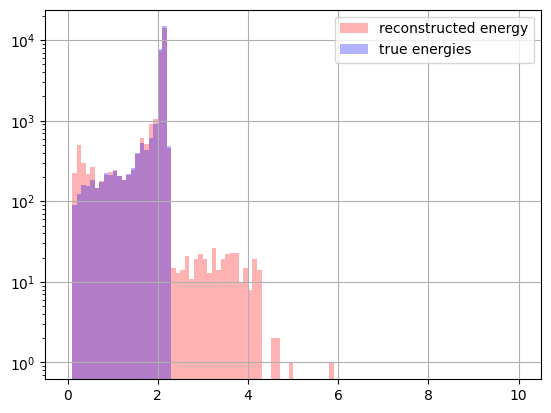

In [3]:
training_data = genfromtxt('training_all_output_false_negative.txt', delimiter=',')
training_data[:,4] =(training_data[:,4]-np.min(training_data[:,4]))/(np.max(training_data[:,4])-np.min(training_data[:,4]))
unique_values, continuous_numbers = np.unique(training_data[:,0], return_inverse=True)
training_data[:,0] = continuous_numbers
# training_data[:,2] = training_data[:,2]*math.pi/180.
# training_data[:,3] = training_data[:,3]*math.pi/180.
training_true = get_true_combinatorics(training_data)

input_training_data = manip_data_ff(training_data,12) ##second param gives number of features

pred_training = train_two_hidden_model(input_training_data,torch.FloatTensor(training_true),12,1000,5e-3,100)

training_reco = get_true_reco_ene(training_data,pred_training[0].tolist(),training_true)

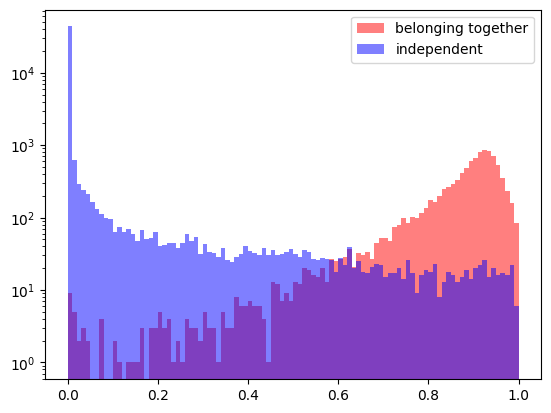

In [4]:
foo_pred = pred_training[0]
training_true = np.array(training_true)
plt.hist(foo_pred[training_true == True],bins=100,range=(0,1),label="belonging together",color="red",alpha=0.5)
plt.hist(foo_pred[training_true == False],bins=100,range=(0,1),label="independent",color="blue",alpha=0.5)
plt.yscale('log')
plt.legend()


### 2) then run the agglo model on the raw dataset test

13497
well reco... 0.8912512037928736


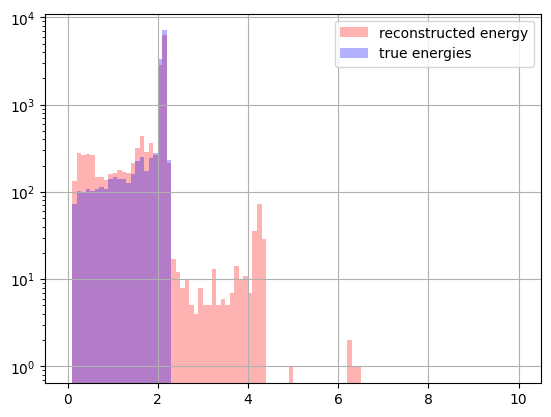

In [5]:
data = genfromtxt('validation_raw.txt', delimiter=',')
data[:,4] = data[:,4]+4500  #this step is needed, I only want positive time values, so that I can use the time as a radius

# ### structure of mydata : eventnr, energy, theta, phi, hit-time
data = data*[1.,1.,3.14159/180,3.14159/180,1.]
unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
data[:,0] = continuous_numbers
out_cluster_agglo = run_agglo_clustering(data,3540)

agglo_true = get_true_combinatorics(data)
agglo_reco = get_true_reco_ene(data,out_cluster_agglo,agglo_true)


### 3) then run the pretrained ff model on the raw dataset test

well reco... 0.5376694569968146


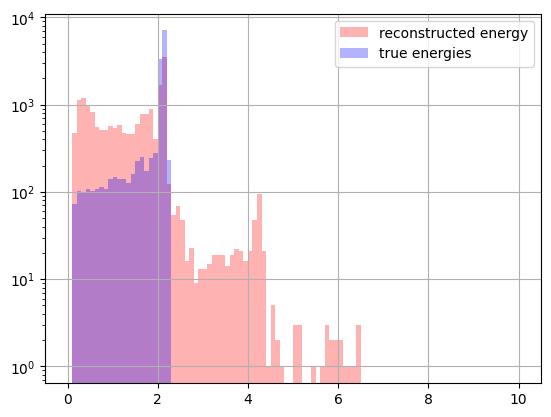

In [6]:
val_data = genfromtxt('validation_raw.txt', delimiter=',')
## some data manipulation needed
val_data[:,4] =(val_data[:,4]-np.min(val_data[:,4]))/(np.max(val_data[:,4])-np.min(val_data[:,4]))
unique_values, continuous_numbers = np.unique(val_data[:,0], return_inverse=True)
val_data[:,0] = continuous_numbers
val_data[:,2] = val_data[:,2]*math.pi/180.
val_data[:,3] = val_data[:,3]*math.pi/180.
val_true = get_true_combinatorics(val_data)
input_val_data = manip_data_ff(val_data,12) ##second param gives number of features

pred_val = validate_two_hidden_model(input_val_data,torch.FloatTensor(val_true),12,1000,5e-3,100)

val_reco = get_true_reco_ene(val_data,pred_val[0].tolist(),val_true)

### 4) combine the outputs of the agglo model and of the ff model and insert them into the "get_agglo_edge_ene"

merge tries:	 2676
correctly merged:	 1086
percentage of correctly merged hits/clusters:
0.40582959641255606
well reco... 0.0
---more statistics....---
fully true_reco_cluster:	 0.7232718381862636
false positive events:	 0.20537897310513448
false negative events:	 0.05423427428317404
mixed false events:	 0.017114914425427872
end of statistiscs------


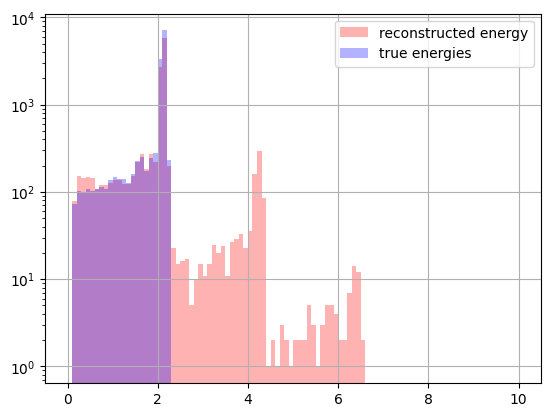

In [11]:
agglo_edge_val = get_agglo_edge_ene(val_data,out_cluster_agglo,pred_val[0].tolist(),val_true)

# second method


### 1) run agglo method and write clustered hits to file

In [12]:
data = genfromtxt('validation_raw.txt', delimiter=',')
data[:,4] = data[:,4]+4500  #this step is needed, I only want positive time values, so that I can use the time as a radius
data = data*[1.,1.,3.14159/180,3.14159/180,1.]
unique_values, continuous_numbers = np.unique(data[:,0], return_inverse=True)
data[:,0] = continuous_numbers
#data = data[:12,:]
val_true = get_true_combinatorics(data)
output_agglo_test = run_agglo_clustering(data,3540)
#plt.hist(data[:,1],bins=100)
#plt.show()
#np.set_printoptions(precision=3,suppress=True)
#print(data)


13497


well reco... 0.0
---more statistics....---
fully true_reco_cluster:	 0.7602222222222222
false positive events:	 0.051111111111111114
false negative events:	 0.17044444444444445
mixed false events:	 0.018222222222222223
end of statistiscs------


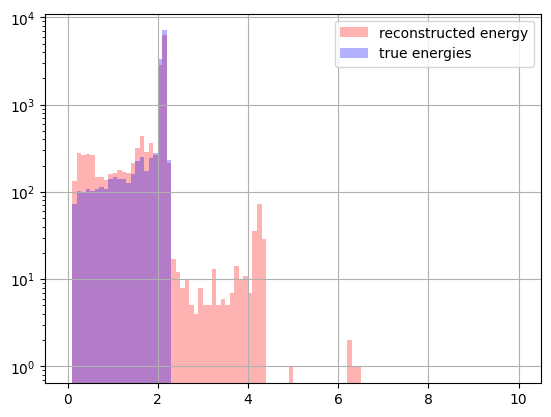

In [13]:
output_agglo = get_true_reco_ene(data,output_agglo_test,val_true)

### 2) save merged hits to file

In [14]:
write_reco_to_file_cms(data,output_agglo_test)
### get array with true values of combinations
test_true = get_true_combinatorics(data)

### 3) run trainded edge model on clustered data

In [15]:
clustered_data = genfromtxt('test_file_agllo_13_02.txt', delimiter=',')
## some data manipulation needed
clustered_data[:,4] =(clustered_data[:,4]-np.min(clustered_data[:,4]))/(np.max(clustered_data[:,4])-np.min(clustered_data[:,4]))
unique_values, continuous_numbers = np.unique(clustered_data[:,0], return_inverse=True)
clustered_data[:,0] = continuous_numbers
clustered_data[:,2] = clustered_data[:,2]*math.pi/180.
clustered_data[:,3] = clustered_data[:,3]*math.pi/180.
#plt.hist(clustered_data[:,1],bins=100)
#plt.show()
input_test_data = manip_data_ff(clustered_data,12)
out_test_edge = validate_two_hidden_model(input_test_data,torch.FloatTensor(test_true),12,1000,5e-3,100)

### 4) merge agglo + edge model

merge tries:	 747
correctly merged:	 662
percentage of correctly merged hits/clusters:
0.8862115127175368
well reco... 0.0
---more statistics....---
fully true_reco_cluster:	 0.8341853745276728
false positive events:	 0.058012891753723046
false negative events:	 0.08957546121360302
mixed false events:	 0.018226272505001112
end of statistiscs------


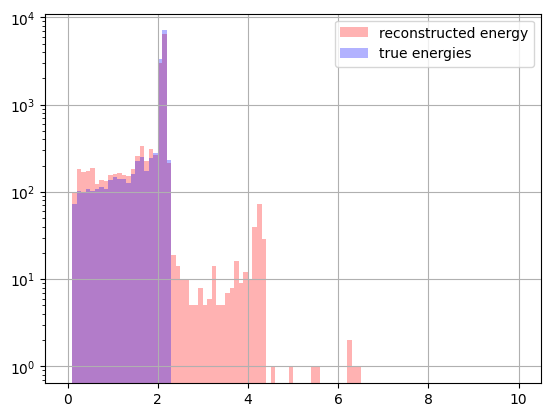

In [16]:
agglo_edge_val = get_agglo_edge_ene(data,output_agglo_test,out_test_edge[0].tolist(),test_true)